In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [2]:
from stage0_configs import *
from modules.helper import *
info = main_config()


Welcome to the Abaqus parameter calibration project


The configurations you have chosen: 

+------------------------+-------------+
|     Global Configs     | User choice |
+------------------------+-------------+
| Number of initial sims |      20     |
|  Initial sims spacing  |     1000    |
|   Optimize strategy    |     SOO     |
|        Material        | DP1000_room |
|     Hardening law      |    Swift    |
|        Geometry        |    NDBR50   |
|      Curve index       |      2      |
|     Optimizer name     |      BO     |
|   Deviation percent    |      5      |
+------------------------+-------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



[0.0, 0.0300013, 0.0600055, 0.0899964, 0.119974, 0.14993, 0.179882, 0.209834, 0.239786, 0.269773, 0.299776, 0.32978, 0.359783, 0.389786, 0.41979, 0.449789, 0.479764, 0.509665, 0.539566, 0.569467, 0.599481, 0.629625, 0.659766, 0.689906, 0.720051, 0.750191, 0.780331, 0.810476, 0.840617, 0.870757, 0.900902, 0.931042, 0.961187, 0.991327, 1.02147, 1.05161, 1.08175, 1.11148, 1.14121, 1.17094, 1.20067, 1.2304, 1.26013, 1.28986, 1.31959, 1.34931, 1.37904, 1.40877, 1.4385, 1.46823, 1.49823, 1.52853, 1.55882, 1.58911, 1.61941, 1.6497, 1.68, 1.71029, 1.74058, 1.77088, 1.80117, 1.83146, 1.86176, 1.89205, 1.92234, 1.95263, 1.98293, 2.01321, 2.04308, 2.07295, 2.10281, 2.1329, 2.16291, 2.19289, 2.2228, 2.25296, 2.28268, 2.313, 2.34291, 2.3729, 2.40361, 2.43348, 2.46269, 2.49333, 2.52359, 2.55344, 2.58253, 2.61314, 2.64386, 2.67346, 2.70281, 2.73294, 2.76352, 2.79339, 2.82223, 2.85212, 2.88334, 2.91374, 2.944, 2.9728, 3.0016]


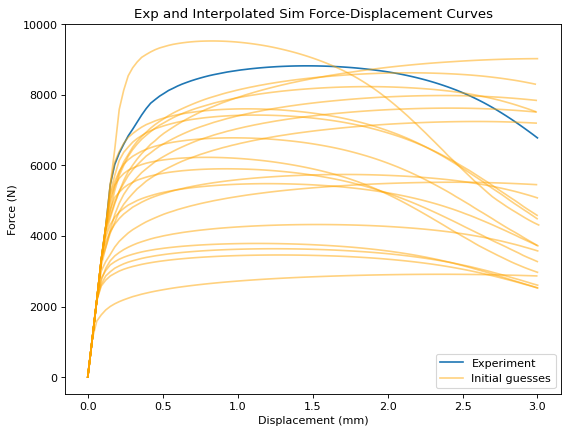

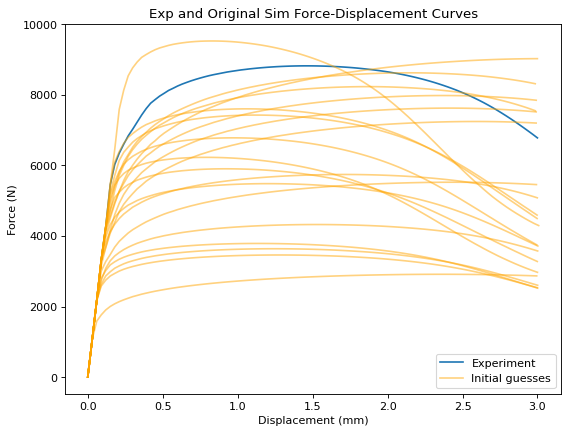

In [3]:
resultPath = info['resultPath']
targetPath = info['targetPath']
# Load csv file
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expForce = target['force/N'].to_numpy()
expDisplacement = target['displacement/mm'].to_numpy() 
#print(max(expDisplacement))
targetCurve = {}
targetCurve['displacement'] = expDisplacement
targetCurve['force'] = expForce

initial_original_FD_Curves = np.load(f"{resultPath}/initial/common/FD_Curves.npy", allow_pickle=True).tolist()
initial_interpolated_FD_Curves = interpolating_FD_Curves(initial_original_FD_Curves, targetCurve)
print(list(initial_interpolated_FD_Curves.values())[0]['displacement'])


# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_interpolated_FD_Curves:
    plt.plot(initial_interpolated_FD_Curves[param]['displacement'], initial_interpolated_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Interpolated Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_original_FD_Curves:
    plt.plot(initial_original_FD_Curves[param]['displacement'], initial_original_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Original Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()



### In total we have 20 initial guesses

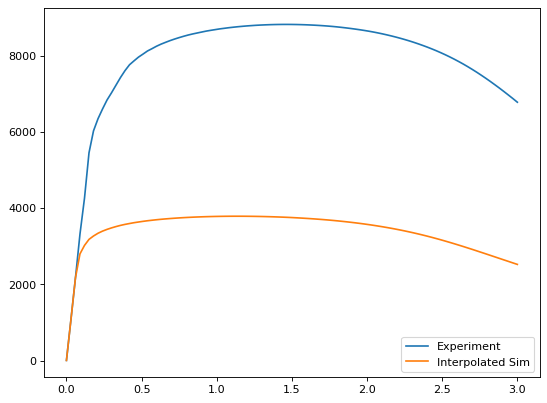

In [4]:
# This is how you call the loss function
# They are in N, not kN
targetForce = targetCurve['force']
targetDisplacement = targetCurve['displacement']
# Datapoint at index i (0 to 19)
i = 0
interpolated_simForce = list(initial_interpolated_FD_Curves.values())[i]['force']

# Plotting the FD curve
figure(figsize=(8, 6), dpi=80)
plt.plot(targetDisplacement, targetForce, label='Experiment')
plt.plot(targetDisplacement, interpolated_simForce, label='Interpolated Sim')
plt.legend()

In [5]:
# Define your loss function. 
# We assume targetForce and simForce are both numpy arrays
# We also assume the force share the same strain points (simForce has been interpolated onto target strain points)
# In our case, both targetForce and simForce are in unit N, not kN
# The loss function should return a single scalar number
# The smaller the number, the better the fit

def lossFD(targetForce, simForce):
    return np.sqrt(np.mean((targetForce - simForce)**2))

In [6]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def calculate_yielding_index(targetDisplacement, targetForce, r2_threshold=0.998):
    """
    This function calculates the end of the elastic (linear) region of the force-displacement curve.
    """
    yielding_index = 0

    # Initialize the Linear Regression model
    linReg = LinearRegression()

    for i in range(2, len(targetDisplacement)):
        linReg.fit(targetDisplacement[:i].reshape(-1, 1), targetForce[:i]) 
        simForce = linReg.predict(targetDisplacement[:i].reshape(-1, 1)) 
        r2 = r2_score(targetForce[:i], simForce) 
        if r2 < r2_threshold:  # If R^2 is below threshold, mark the end of linear region
            yielding_index = i - 1
            break
    return yielding_index

def loss_elastic(targetDisplacement, targetForce, simForce, w_res=0.95, w_slope=0.05):
    """
    This function calculates the loss for the elastic region of the force-displacement curve. 
    The loss is a weighted sum of the residuals loss and slope loss.
    """
    # Calculate residuals and corresponding loss
    residuals = targetForce - simForce
    residuals_loss = np.sqrt(np.mean(residuals ** 2))
    
    # Calculate slopes and corresponding loss
    slope_true = np.diff(targetForce) / np.diff(targetDisplacement)
    slope_pred = np.diff(simForce) / np.diff(targetDisplacement)
    slope_loss = np.sqrt(np.mean((slope_true - slope_pred) ** 2))

    # Weighted loss calculation
    loss = w_res * residuals_loss + w_slope * slope_loss

    return loss

def loss_plastic_mono_mono(targetDisplacement, targetForce, simForce, w_res=0.75, w_slope=0.25):
    """
    This function calculates the loss for the monotonic plastic region of the force-displacement curve.
    The loss is a weighted sum of the residuals loss and slope loss.
    """
    # Calculate residuals and corresponding loss
    residuals = targetForce - simForce
    residuals_loss = np.sqrt(np.mean(residuals ** 2))
    
    # Calculate slopes and corresponding loss
    slope_true = np.diff(targetForce) / np.diff(targetDisplacement)
    slope_pred = np.diff(simForce) / np.diff(targetDisplacement)
    slope_loss = np.sqrt(np.mean((slope_true - slope_pred) ** 2))

    # Weighted loss calculation
    loss = w_res * residuals_loss + w_slope * slope_loss

    return loss

def loss_plastic_peak_peak(targetDisplacement, targetForce, simForce, w_res=0.75, w_slope=0.25, w_peak=0.1):
    """
    This function calculates the loss for the non-monotonic plastic region of the force-displacement curve. 
    The loss is a weighted sum of the residuals loss, slope loss, and peak penalty.
    """
    # Calculate residuals and corresponding loss
    residuals = targetForce - simForce
    residuals_loss = np.sqrt(np.mean(residuals ** 2))

    # Calculate slopes and corresponding loss
    slope_true = np.diff(targetForce) / np.diff(targetDisplacement)
    slope_pred = np.diff(simForce) / np.diff(targetDisplacement)
    slope_loss = np.sqrt(np.mean((slope_true - slope_pred) ** 2))

    # Calculate peak penalty
    peak_true = np.argmax(targetForce)
    peak_pred = np.argmax(simForce)
    peak_penalty = abs(targetForce[peak_true] - simForce[peak_pred])

    # Weighted loss calculation
    loss = w_res * residuals_loss + w_slope * slope_loss + w_peak *peak_penalty

    return loss

def loss_plastic_peak_mono(targetDisplacement, targetForce, simForce, w_res=0.75, w_slope=0.25, w_peak=0.1):
    pass

def loss_plastic_mono_peak(targetDisplacement, targetForce, simForce, w_res=0.75, w_slope=0.25, w_peak=0.1):
    pass

# Function to check if a sequence is monotonic
def is_monotonic(y):
    return np.all(np.diff(y) >= 0)
    
# Define the main custom loss function
def custom_loss_func(targetDisplacement,targetForce, simForce):
    # Calculate the end of the elastic region
    yielding_index = calculate_yielding_index(targetDisplacement, targetForce)
    elastic_loss = loss_elastic(targetDisplacement[:yielding_index], targetForce[:yielding_index], simForce[:yielding_index])
    
    if (is_monotonic(targetForce) and is_monotonic(simForce)):
        plastic_loss = loss_plastic_mono_mono(targetDisplacement[yielding_index:], targetForce[yielding_index:], simForce[yielding_index:])
    elif (is_monotonic(targetForce) and not is_monotonic(simForce)):
        plastic_loss = loss_plastic_mono_peak(targetDisplacement[yielding_index:], targetForce[yielding_index:], simForce[yielding_index:])
    elif (not is_monotonic(targetForce) and is_monotonic(simForce)):
        plastic_loss = loss_plastic_peak_mono(targetDisplacement[yielding_index:], targetForce[yielding_index:], simForce[yielding_index:])
    elif (is_monotonic(targetForce) and not is_monotonic(simForce)):
        plastic_loss = loss_plastic_peak_peak(targetDisplacement[yielding_index:], targetForce[yielding_index:], simForce[yielding_index:])
    total_loss = elastic_loss + plastic_loss
    return total_loss


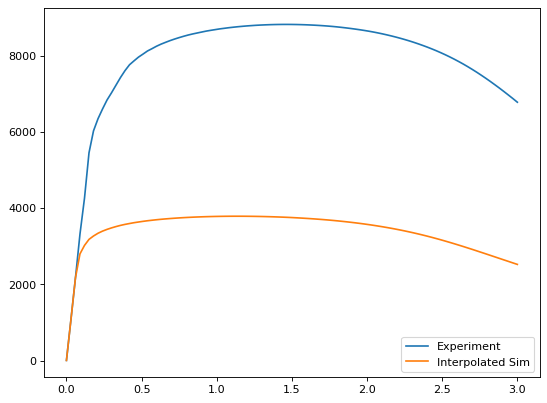

6604.591739698115
4628.102128071323


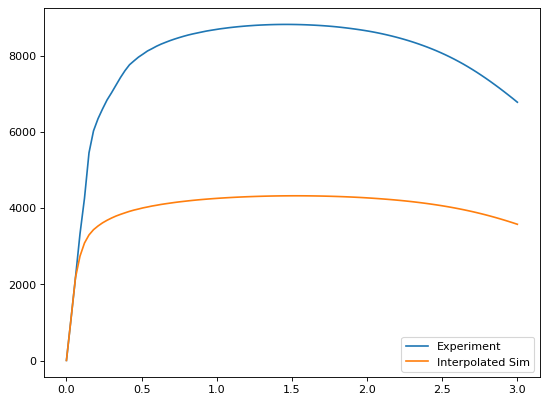

5942.4558562106395
4020.7645501546917


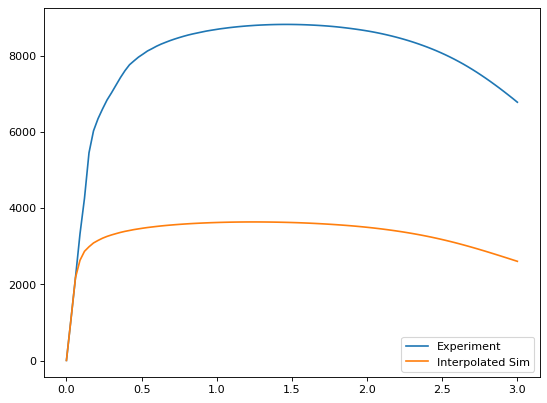

6869.166510745677
4716.61214207903


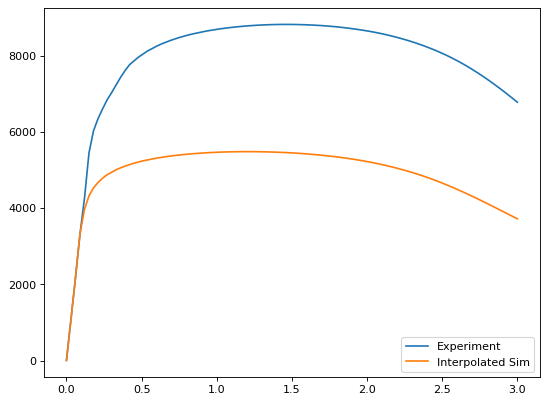

4220.448913833412
3097.199909851865


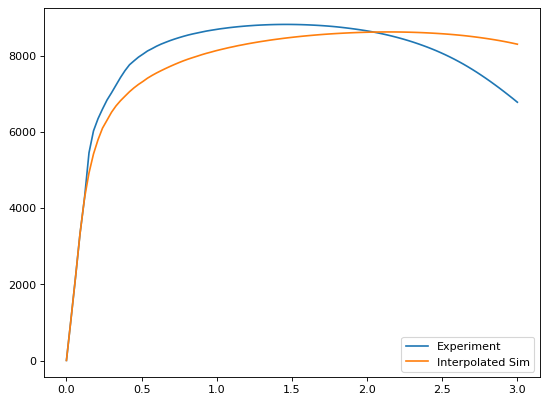

1356.0253796567172
593.4830899373833


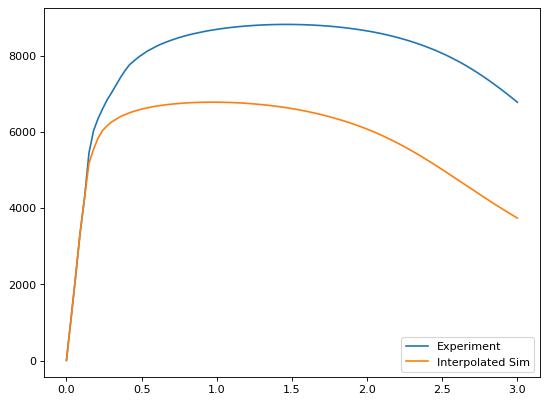

2599.671905581442
2278.895243624925


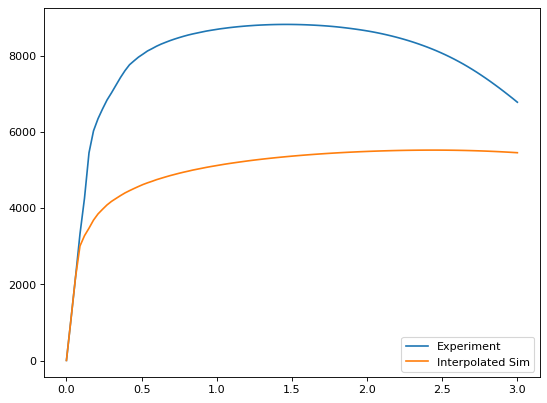

4865.464995212447
3006.0090629533543


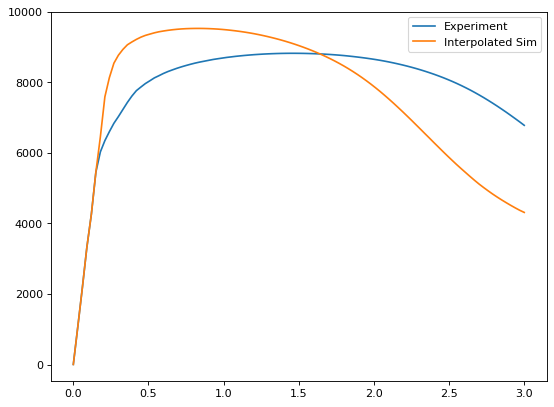

2032.5000983466218
1394.9283583645358


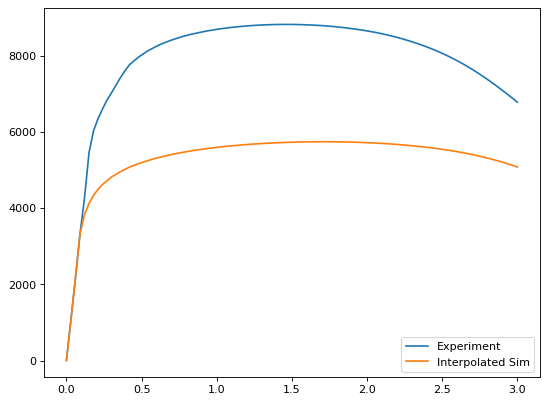

4050.6531887148512
2694.125232316966


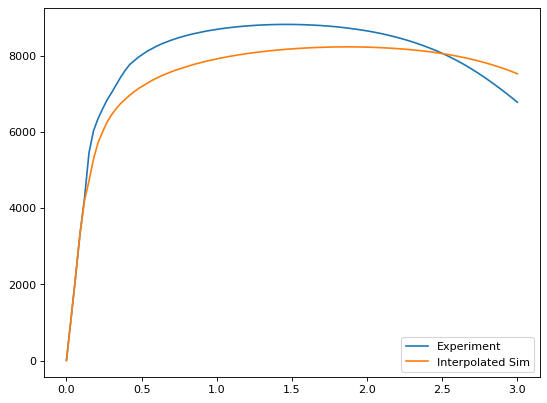

1540.775010178505
588.5402397414238


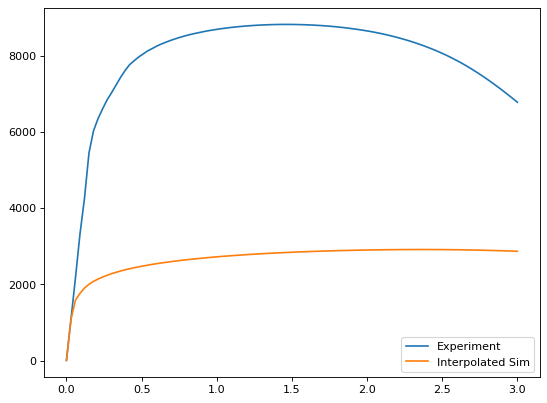

8323.25650662724
5351.029054877099


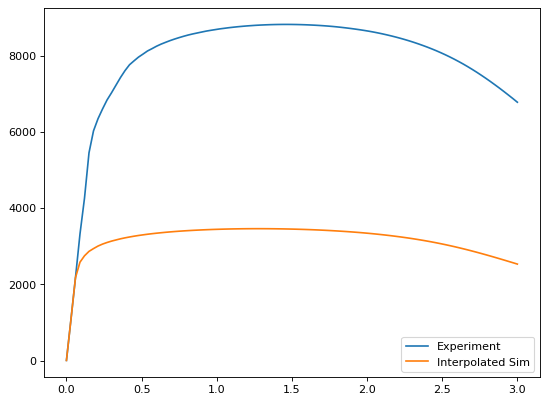

7121.693213669903
4864.330077293526


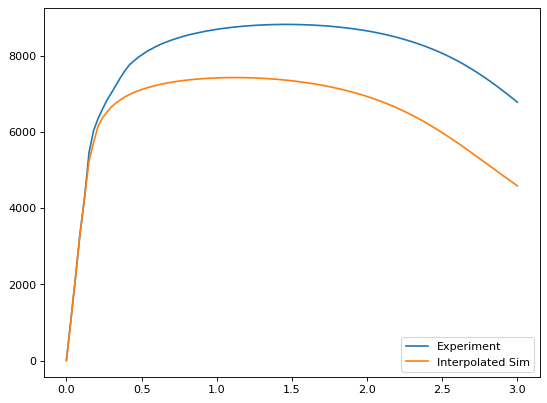

1848.8770182460285
1545.8994850786328


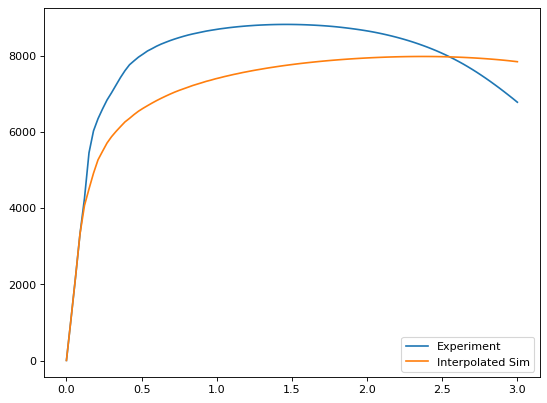

2109.282361122566
975.263900396446


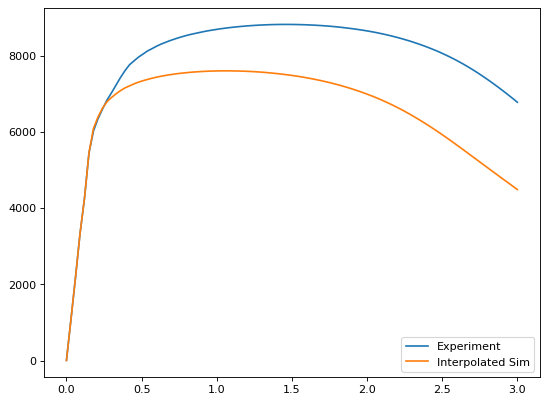

1558.1959786462585
1496.4416473601423


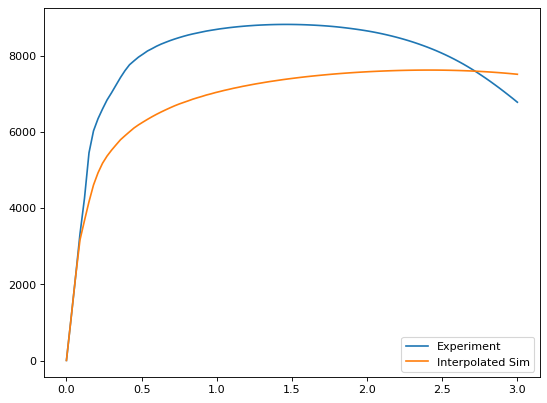

2582.960614316466
1259.4272130120464


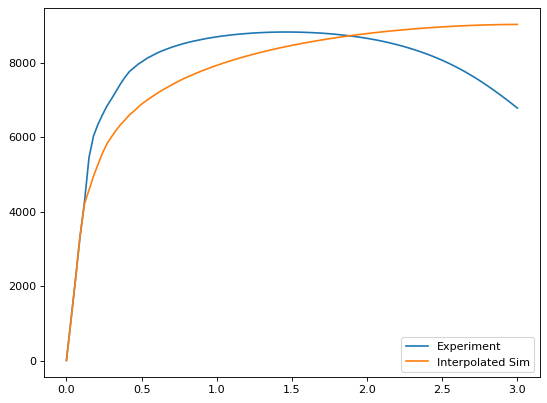

2049.825378979296
912.3359763816676


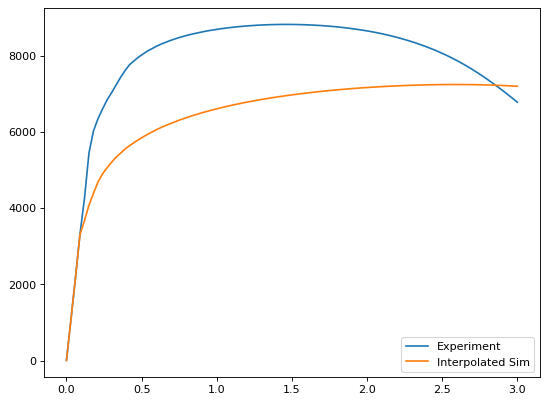

3049.979654997913
1606.3377150094784


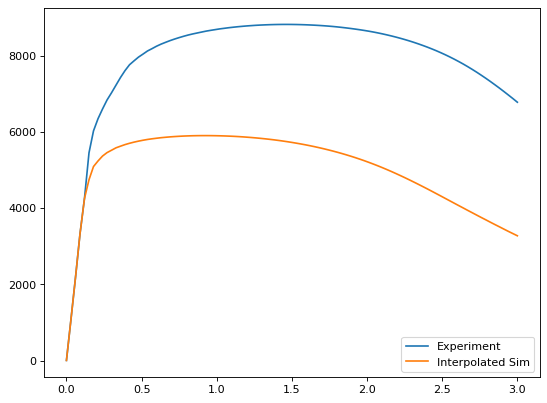

3820.8324305719734
3014.0758906577757


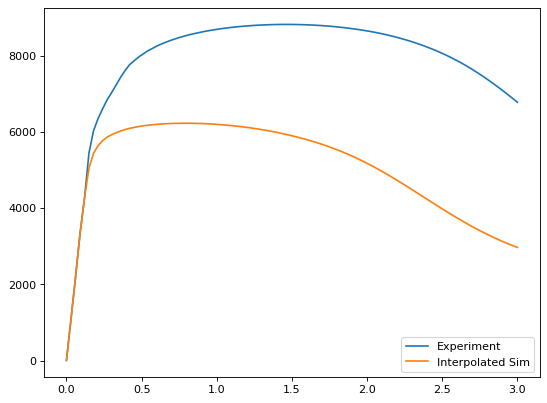

3470.2025090581033
3012.270507458903


In [10]:
# For each interpolated simulation curve, calculate the loss and plot the sim curve against target curve

for i in range(len(initial_interpolated_FD_Curves)):
    interpolated_simForce = list(initial_interpolated_FD_Curves.values())[i]['force']

    # Plotting the FD curve
    figure(figsize=(8, 6), dpi=80)
    plt.plot(targetDisplacement, targetForce, label='Experiment')
    plt.plot(targetDisplacement, interpolated_simForce, label='Interpolated Sim')
    plt.legend()
    plt.show()
    print(custom_loss_func(targetDisplacement,targetForce, interpolated_simForce))
    print(lossFD(targetForce, interpolated_simForce))

